In [1]:
import numpy as np
import pandas as pd
import sqlite3
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.svm import SVC


In [2]:
path = "data/KMeansSMOTE_O_M_SelectedFeatures.csv"
df= pd.read_csv(path)
x = df.iloc[:, :-1]
y = df.iloc[:, -1]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
x_train.shape

(21518, 61)

In [3]:
path.split("/")[1].split(".")[0]

'KMeansSMOTE_O_M_SelectedFeatures'

In [4]:
def createDB():
    with sqlite3.connect("data/models_Reports_WareHouse.db") as conn:
        cursor = conn.cursor()

        cursor.execute("""
            CREATE TABLE IF NOT EXISTS TEST_METADATA (
                test_id INTEGER PRIMARY KEY AUTOINCREMENT,
                timestamp TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
                model_name TEXT,
                dataset_name TEXT,
                dataset_version TEXT,
                test_type TEXT,
                notes TEXT
            );
        """)

        cursor.execute("""
            CREATE TABLE IF NOT EXISTS MODEL_PARAMETERS (
                test_id INTEGER,
                hyperparameters TEXT,
                FOREIGN KEY (test_id) REFERENCES TEST_METADATA(test_id)
            );
        """)

        cursor.execute("""
            CREATE TABLE IF NOT EXISTS METRICS (
                test_id INTEGER,
                anomaly TEXT,
                normal TEXT,
                accuracy TEXT,
                macro_avg TEXT,
                weighted_avg TEXT,
                FOREIGN KEY (test_id) REFERENCES TEST_METADATA(test_id)
            );
        """)

def  save_REPORT(report:dict , model:BaseEstimator , dataset_version:str , notes:str, test_type:str = "Classification" , dataset_name:str =path.split("/")[1].split(".")[0]):
    with sqlite3.connect("data/models_Reports_WareHouse.db") as conn:
        cursor = conn.cursor()

        cursor.execute("""
            INSERT INTO TEST_METADATA (model_name, dataset_name, dataset_version, test_type, notes)
            VALUES (?, ?, ?, ?, ?)
        """ , (type(model).__name__, dataset_name, dataset_version, test_type, notes)
       )

        # Get the auto-generated test_id
        test_id = cursor.lastrowid

        cursor.execute("""
            INSERT INTO MODEL_PARAMETERS (test_id, hyperparameters)
            VALUES (? , ? )
        """, (test_id,str(model.get_params()))
        )


        cursor.execute("""
            INSERT INTO METRICS (test_id, anomaly, normal, accuracy, macro_avg, weighted_avg)
            VALUES (?, ?, ?, ?, ?, ?)
        """, (
            test_id,
            str(report["anomaly"]),
            str(report["normal"]),
            str(report["accuracy"]),
            str(report["macro avg"]),
            str(report["weighted avg"])
        )
   )

        conn.commit()



In [5]:
from sklearn.metrics import classification_report

def generate_metric_report(y_true:np.array, y_pred:pd.Series ,model:BaseEstimator  , dataset_version:str , notes:str  , test_type:str = "Classification")->pd.DataFrame:
    report = pd.DataFrame(classification_report(y_true, y_pred, output_dict=True))
    report.iloc[:-1, :] = report.iloc[:-1, :] *100
    for i, col in enumerate(report.columns):
        report.iloc[:-1, i] = report.iloc[:-1, i].apply( lambda v: round(v, 2) )

    save_REPORT(report.to_dict('series'), model , "v1", notes, test_type)

    return report

In [10]:
c_range = np.arange(2.2,4.7, 0.2)
recalls = []

for c in tqdm(c_range):
    clf_svc = SVC(kernel = "linear", C = c)
    clf_svc.fit(x_train, y_train)
    svc_pred = clf_svc.predict(x_test)
    recalls.append(generate_metric_report(y_test, svc_pred, clf_svc, 'SMOTE_OM', 'diffent cs').loc["recall"]["anomaly"] )

100%|██████████| 13/13 [05:18<00:00, 24.50s/it]


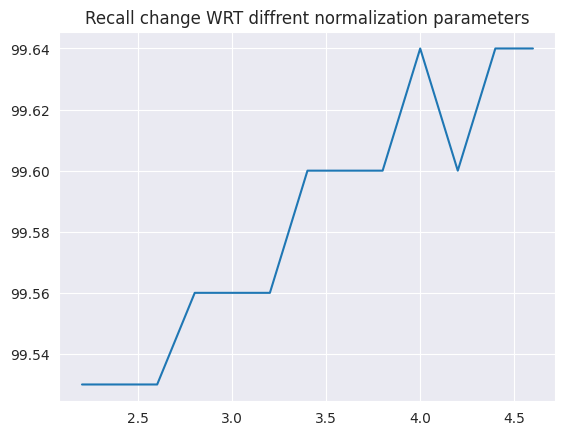

In [11]:
recalls = np.array(recalls)
sns.lineplot(x= c_range, y= recalls)
plt.title("Recall change WRT diffrent normalization parameters")
plt.show()


In [13]:
clf_svc = SVC(kernel = "linear", C = 4)
clf_svc.fit(x_train, y_train)
svc_pred = clf_svc.predict(x_test)
generate_metric_report(y_test, svc_pred, clf_svc, 'SMOTE_OM', "")

anomaly   normal  accuracy  macro avg  weighted avg
precision    99.78    99.58  99.68000      99.68         99.68
recall       99.60    99.77  99.68000      99.69         99.68
f1-score     99.69    99.68  99.68000      99.68         99.68
support    2754.00  2626.00   0.99684    5380.00       5380.00

In [14]:
from sklearn.tree import plot_tree, DecisionTreeClassifier

# https://medium.com/data-science/decision-tree-classifier-explained-a-visual-guide-with-code-examples-for-beginners-7c863f06a71e
dt_clf = DecisionTreeClassifier(
    max_depth=None,           # Maximum depth of the tree
    min_samples_split=2,      # Minimum number of samples required to split an internal node
    min_samples_leaf=1,       # Minimum number of samples required to be at a leaf node
    criterion='entropy'       # Function to measure the quality of a split
)
dt_clf.fit(x_train, y_train)

decisionTree_pred = dt_clf.predict(x_test)

generate_metric_report(y_test,decisionTree_pred ,  model= dt_clf , dataset_version = "v1" , notes = "Test Report")

anomaly   normal   accuracy  macro avg  weighted avg
precision    99.82    99.62  99.720000      99.72         99.72
recall       99.64    99.81  99.720000      99.72         99.72
f1-score     99.73    99.71  99.720000      99.72         99.72
support    2754.00  2626.00   0.997212    5380.00       5380.00

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10), dpi=1000)

plot_tree(dt_clf, filled=True, feature_names=x_test.columns,
          class_names=['Anomaly', 'Normal'], impurity=False)
plt.show()

In [16]:
#https://medium.com/analytics-vidhya/evaluating-a-random-forest-model-9d165595ad56
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier()
forest.fit(x_train, y_train)
randomForest_pred = forest.predict(x_test)
generate_metric_report(y_test,randomForest_pred ,  model= forest , dataset_version = "v1" , notes = "Testing Random Forest with it's raw parameters")

anomaly   normal   accuracy  macro avg  weighted avg
precision    99.96    99.73  99.850000      99.85         99.85
recall       99.75    99.96  99.850000      99.85         99.85
f1-score     99.85    99.85  99.850000      99.85         99.85
support    2754.00  2626.00   0.998513    5380.00       5380.00